# Laboratoire 2: Apprendre à reconnaître des objet¶


No d’équipe: 12



## Introduction 

Lors de ce laboratoire, notre mandat était de construire et comparer des modèles d’apprentissage machine pour la reconnaissance d’objets simple. On veut permettre notre machine Cozmo d’identifier rapidement des marqueurs utilisé lors du laboratoire 1. 

Les objectifs du laboratoire sont de créer un ensemble et faire des modifications nécessaire pour faciliter la détection de formes. On peut soit réduire la taille de l’image, appliquer un flou, appliquer un filtre gris ou augmenté les données. Le défi se trouve dans l’applications de ses altérations pour arriver à une précision raisonnable.

Pour commencer, ce rapport présentera un court description des points 2, 3 et 4, les résultats des modèle d’apprentissage et notre EnsembleB afin que vous puissiez reproduire nos résultats. 


In [11]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import imutils
import random
import os
import pickle
import Augmentor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from tqdm import tqdm_notebook
from matplotlib.pyplot import imread
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from skimage.feature.texture import greycomatrix, greycoprops, local_binary_pattern
from sklearn.metrics import classification_report,confusion_matrix

### Augmentation de données 

Voici comment nous avons augmenter nos donnée pour agrandir le nombre de donnée de notre Ensemble B qui est petit pour le momment.

On doit donner le path (data_directory) et le nombre image augmenter que nous voulons (nb_img)

Les augmentations : 

1. 2 rotation
2. retourner à droite et à gauche
3. inclinaison
4. une distortion sur l'image

On fait deux rotations, une rotation de 90 degrée et une rotation de 270 degree. On retourne l'image de droite à gauche et de haut vers le bas. ensuite, on fait un tilt de l'image pour finalement ajouter une distorsion sur l'image.



In [12]:
def dataset_augmentation(data_directory, nb_img):
    # Path to the image dataset
    p = Augmentor.Pipeline(str(data_directory), output_directory=".")

    # Operations to be performed on the images:
    p.rotate90(probability=0.2)
    p.rotate270(probability=0.2)
    p.flip_left_right(probability=0.30)
    p.flip_top_bottom(probability=0.30)
    p.skew_tilt(probability=0.25, magnitude=0.1)
    p.random_distortion(probability=1, grid_width=2, grid_height=2, magnitude=4)

    # Specifyin the number of images to generate
    p.sample(nb_img)

In [13]:
#example d'augmentation sur les image de triangle 2
# A_triangle2 = "Data/EnsembleB_H2020/Triangles/Triangle2"
# dataset_augmentation(A_triangle2,1000)

## CRÉATION D'UN DATASET

Nous avons manuellement modifier l'Ensemble A. Nous avons prit 5 images des dossier cercle, diamand, hexagonne et triangle (1 et 5).

Nous avons seulement pris la section des images qui comprenait le markeur pour ces 5 images

In [14]:
# Define the base data directory path
dataDir = Path.cwd() / "EnsembleB_H2020"

# Create a variable that contains the labels of different classes and their dir path
CLASSES = [
    {
        "LABEL": "Circle2", 
        "NUMERIC": 0,
        "PATH": os.path.join(dataDir, 'Circles', 'Circle2')
    },
    {
        "LABEL": "Circle5", 
        "NUMERIC": 1,
        "PATH": os.path.join(dataDir, 'Circles', 'Circle5')
    },
    {
        "LABEL": "Diamond2",
        "NUMERIC": 2,
        "PATH": os.path.join(dataDir, 'Diamonds', 'Diamond2')
    },
    {
        "LABEL":"Diamond5", 
        "NUMERIC": 3,
        "PATH": os.path.join(dataDir, 'Diamonds', 'Diamond5')
    },
    {
        "LABEL":"Hexagon2", 
        "NUMERIC": 4,
        "PATH": os.path.join(dataDir, 'Hexagons', 'Hexagon2')
    },
    {
        "LABEL":"Hexagon5", 
        "NUMERIC": 5,
        "PATH": os.path.join(dataDir, 'Hexagons', 'Hexagon5')
    },
    {
        "LABEL":"Trianlge2", 
        "NUMERIC": 6,
        "PATH": os.path.join(dataDir, 'Triangles', 'Triangle2')
    },
    {
        "LABEL":"Triangle5", 
        "NUMERIC": 7,
        "PATH": os.path.join(dataDir, 'Triangles', 'Triangle5')
    }
]

 **Nous avons déja fait ces augmentations** 
Dans notre implémentation, nous avons décidé de réduire l’image a une dimension de 160x160.
Nous avons décidé d’extraire la région d'intérêt de nos images automatiquement. Avec l’aide de la bibliothèque OpenCV et les manipulation amener au images (réduction, filtre gris et flou) on peut trouver le contoure plus facilement. 
On applique un filtre gris sur l’image avant de réduire sa taille. Ce filtre permet à notre algorithmes de détecter les gradient de couleurs plus facilement. Elle facilite la détection de forme. 
On applique un Gaussian blur nous images pour compter le nombre de contours. Cette manipulation est fait à l'aide de la bibliothèques OpenCV, un algorithme de détections de formes.

In [17]:
# Create an empty list for saving the data
dataSet = []

# A variable that defines final image size
imsize = (160, 160)

# Read all the files from circle2Dir and append to dataset
for CLASS in CLASSES:
    print(f"=> Reading files from class {CLASS['LABEL']}")
    for image in tqdm(glob(os.path.join(CLASS["PATH"], '*'))):
        # Read the image in grayscale (single-channel)
        gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        # Resize the image to a smaller size
        gray = cv2.resize(gray, imsize)
        
        # calculate countors from the gray image
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # a variable where polygons will be saved
        polygons = []
        
        # Save the polygons
        for contour in contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            polygons.append(len(approx))
        
        # A variable which is going to be features
        feature = [0 for i in range(16)]
        
        # Create the feature vector from polygons
        for polygon in polygons:
            feature[polygon] += 1
        
        # create a data variable to be appended to dataset
        data = {
            'image': gray,
            'polygons': polygons,
            'feature': feature,
            'label': CLASS['NUMERIC']
        }
        
        # Append data to dataSet
        dataSet.append(data)                         

=> Reading files from class Circle2


  0%|          | 0/137 [00:00<?, ?it/s]

=> Reading files from class Circle5


  0%|          | 0/58 [00:00<?, ?it/s]

=> Reading files from class Diamond2


  0%|          | 0/246 [00:00<?, ?it/s]

=> Reading files from class Diamond5


  0%|          | 0/153 [00:00<?, ?it/s]

=> Reading files from class Hexagon2


  0%|          | 0/214 [00:00<?, ?it/s]

=> Reading files from class Hexagon5


  0%|          | 0/260 [00:00<?, ?it/s]

=> Reading files from class Trianlge2


  0%|          | 0/216 [00:00<?, ?it/s]

=> Reading files from class Triangle5


  0%|          | 0/87 [00:00<?, ?it/s]

In [6]:
# Shuffles the images
random.shuffle(dataSet)


# create the X and y from DataSet
X = np.array([data['feature'] for data in dataSet])
y = np.array([data['label'] for data in dataSet])

# Creating the files containing all the information about your model and saving them to the disk
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

In [9]:
X_train = X_train.flatten()
X_test = X_test.flatten()
X_val = X_val.flatten()

In [10]:
X_train = X_train.reshape(len(y_train), len(X[0]))
X_test = X_test.reshape(len(y_test),len(X[0]))
X_val = X_val.reshape(len(y_val), len(X[0]))

## Reseau Neural

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    o = sigmoid(z)
    return o*(1-o)
 
def summation(w, X):
    return np.dot(w,X)

def softmax(x):
    e_x = np.exp(x - np.max(x)) 
    return e_x / e_x.sum(axis=0)

def mle(y, axis=1):
    return np.argmax(y, axis)

def cross_entropy(outputs, y_target):
    return -np.sum(y_target*np.log(outputs))

In [12]:
class RNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=15, epochs=300, 
                 learning_rate=0.01, n_batches=1):

        # Parametre du reseau
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units       
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()
        self.learning_rate = learning_rate
        self.epochs = epochs
        
    def weights(self):

        w1 = np.random.rand(self.n_hidden_units, self.n_features)        
        w2 = np.random.rand(self.n_classes, self.n_hidden_units)        

        return w1, w2
    
    def error(self, y, output):
        error = cross_entropy(output, y)
        return 0.5 * np.mean(error)
    
    def forward(self, X):
        
        z1 = summation(self.w1, X.T) 
        hidden_output = sigmoid(z1)         
        z2 = summation(self.w2, hidden_output)  
        final_output = sigmoid(z2)        

        return z1, hidden_output, z2, final_output
    
    def backward(self, X, z1, hidden_output, final_output, y):
        
        output_error = final_output - y

        output_delta = self.w2.T.dot(output_error) * sigmoid_prime(z1)

        grad1 = output_delta.dot(X)

        grad2 = output_error.dot(hidden_output.T)
        
        return grad1, grad2   

    def backprop_step(self, X, y):
        z1, hidden_output, z2, final_output = self.forward(X)
        y = y.T

        grad1, grad2 = self.backward(X, z1, hidden_output, final_output, y)
        
        error = self.error(y, final_output)

        return error, grad1, grad2 
    
    def fit(self, X, y):
        self.error_ = []  
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y)
        
        X_bathces = np.array_split(X, self.n_batches)
        y_bathces = np.array_split(y, self.n_batches)      

        for i in range(self.epochs):

            epoch_errors = []

            for Xi, yi in zip(X_bathces, y_bathces):

                error, grad1, grad2 = self.backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
            print(i, np.mean(epoch_errors))
        return self
    
    def predict(self, X):        
        z1, hidden_output, z2, final_output = self.forward(X)
        return mle(z2.T)

    def predict_proba(self, X):        
        z1, hidden_output, z2, final_output = self.forward(X)
        return softmax(final_output.T)

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])
    

In [13]:
N_FEATURES = len(X[0])

# Avec EsembleB
N_CLASSES = 8

nn = RNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=50,    # nombre de neurones dans la couche
    epochs=2500,
    learning_rate=0.001,
    n_batches=35,
).fit(X_train, y_train);

0 117.91573170948406
1 150.15058401856592
2 148.84381968822254
3 147.4856007188641
4 146.06288892200132
5 144.56789212674573
6 142.99883632232314
7 141.36038742345244
8 139.66358222932405
9 137.9250312009285
10 136.16532026998053
11 134.40678742531853
12 132.67108408632035
13 130.9770278252889
14 129.33915201655586
15 127.76711569023745
16 126.26588351635448
17 124.8364297148881
18 123.47668840722031
19 122.18252794593229
20 120.94861201058505
21 119.76908656652215
22 118.6380838945489
23 117.55006333688925
24 116.50001979366186
25 115.48359228159586
26 114.49710117148398
27 113.53753723013976
28 112.60252001494233
29 111.69023828671047
30 110.79938118146136
31 109.92906591301767
32 109.07876565142128
33 108.24823978439574
34 107.43746786690339
35 106.64658805583444
36 105.8758405880971
37 105.12551678306716
38 104.39591404468872
39 103.68729733441569
40 102.9998675354168
41 102.33373700597367
42 101.68891242320922
43 101.06528476385309
44 100.46262598684778
45 99.88059170958358
46 99.

382 63.51707327180167
383 63.47802449730334
384 63.43911470025721
385 63.40034260368936
386 63.361706938802364
387 63.32320644506204
388 63.28483987027716
389 63.24660597067234
390 63.20850351095434
391 63.17053126437202
392 63.132688012770124
393 63.09497254663725
394 63.05738366514799
395 63.019920176199825
396 62.982580896444546
397 62.945364651314904
398 62.90827027504608
399 62.87129661069294
400 62.834442510142395
401 62.79770683412198
402 62.76108845220402
403 62.72458624280603
404 62.688199093187556
405 62.651925899443164
406 62.61576556649244
407 62.57971700806654
408 62.54377914669172
409 62.50795091367012
410 62.472231249057636
411 62.43661910163937
412 62.401113428902434
413 62.36571319700662
414 62.33041738075277
415 62.29522496354909
416 62.26013493737563
417 62.22514630274683
418 62.19025806867241
419 62.155469252616705
420 62.12077888045644
421 62.08618598643725
422 62.05168961312874
423 62.0172888113785
424 61.98298264026505
425 61.9487701670496
426 61.91465046712718
4

752 52.98638124395493
753 52.96265963670252
754 52.9389594342487
755 52.91528065083173
756 52.891623299870176
757 52.86798739396966
758 52.844372944930036
759 52.82077996375305
760 52.797208460650495
761 52.773658445052874
762 52.75012992561853
763 52.72662291024323
764 52.70313740607006
765 52.67967341950015
766 52.65623095620328
767 52.63281002112944
768 52.609410618520414
769 52.58603275192195
770 52.56267642419631
771 52.53934163753513
772 52.51602839347268
773 52.492736692899506
774 52.469466536076375
775 52.4462179226486
776 52.4229908516606
777 52.39978532157092
778 52.37660133026736
779 52.353438875082574
780 52.330297952809744
781 52.307178559718785
782 52.284080691572505
783 52.2610043436432
784 52.237949510729436
785 52.21491618717296
786 52.19190436687596
787 52.16891404331834
788 52.14594520957535
789 52.12299785833525
790 52.100071981917154
791 52.07716757228902
792 52.054284621085856
793 52.03142311962784
794 52.008583058938775
795 51.98576442976444
796 51.96296722259112

1126 45.67897377061712
1127 45.6639946532808
1128 45.64903912337056
1129 45.63410713675609
1130 45.619198649096305
1131 45.60431361584401
1132 45.58945199225089
1133 45.574613733372125
1134 45.55979879407122
1135 45.545007129024626
1136 45.53023869272636
1137 45.515493439492694
1138 45.50077132346658
1139 45.48607229862224
1140 45.47139631876963
1141 45.456743337558734
1142 45.44211330848415
1143 45.42750618488916
1144 45.41292191997025
1145 45.398360466781185
1146 45.38382177823723
1147 45.36930580711938
1148 45.354812506078325
1149 45.34034182763864
1150 45.32589372420268
1151 45.311468148054594
1152 45.29706505136426
1153 45.28268438619113
1154 45.26832610448805
1155 45.253990158105054
1156 45.23967649879313
1157 45.22538507820786
1158 45.21111584791309
1159 45.19686875938454
1160 45.182643764013356
1161 45.16844081310959
1162 45.15425985790577
1163 45.140100849560184
1164 45.12596373916037
1165 45.11184847772643
1166 45.097755016214286
1167 45.08368330551894
1168 45.06963329647776


1484 41.477754315811666
1485 41.46845469432812
1486 41.45916527397987
1487 41.44988603767491
1488 41.440616968424706
1489 41.431358049343736
1490 41.422109263649006
1491 41.412870594659566
1492 41.403642025796024
1493 41.39442354058
1494 41.385215122633724
1495 41.376016755679444
1496 41.366828423538955
1497 41.35765011013309
1498 41.34848179948132
1499 41.339323475700986
1500 41.330175123007045
1501 41.32103672571145
1502 41.31190826822263
1503 41.30278973504495
1504 41.293681110778245
1505 41.28458238011727
1506 41.27549352785113
1507 41.266414538862875
1508 41.257345398128784
1509 41.24828609071804
1510 41.23923660179201
1511 41.2301969166038
1512 41.221167020497774
1513 41.21214689890887
1514 41.203136537362134
1515 41.19413592147222
1516 41.18514503694274
1517 41.176163869565826
1518 41.16719240522148
1519 41.158230629877075
1520 41.149278529586844
1521 41.140336090491196
1522 41.13140329881629
1523 41.12248014087339
1524 41.11356660305841
1525 41.104662671851194
1526 41.095768333

1840 38.72781144511081
1841 38.72149497975719
1842 38.71518551927151
1843 38.70888305611769
1844 38.70258758275666
1845 38.69629909164631
1846 38.69001757524172
1847 38.683743025995035
1848 38.677475436355714
1849 38.67121479877039
1850 38.66496110568308
1851 38.65871434953522
1852 38.652474522765665
1853 38.64624161781081
1854 38.64001562710466
1855 38.63379654307881
1856 38.627584358162615
1857 38.621379064783206
1858 38.61518065536547
1859 38.60898912233225
1860 38.602804458104366
1861 38.59662665510061
1862 38.59045570573787
1863 38.58429160243119
1864 38.57813433759382
1865 38.571983903637275
1866 38.56584029297142
1867 38.55970349800448
1868 38.5535735111432
1869 38.547450324792784
1870 38.54133393135705
1871 38.53522432323848
1872 38.52912149283826
1873 38.523025432556295
1874 38.516936134791415
1875 38.51085359194133
1876 38.5047777964026
1877 38.498708740570976
1878 38.49264641684118
1879 38.486590817607144
1880 38.48054193526197
1881 38.474499762198
1882 38.468464290807034
18

2199 36.853203211572705
2200 36.84892782109406
2201 36.84465687803212
2202 36.84039037616128
2203 36.83612830926185
2204 36.83187067112015
2205 36.82761745552829
2206 36.823368656284366
2207 36.8191242671924
2208 36.81488428206227
2209 36.81064869470986
2210 36.80641749895694
2211 36.802190688631235
2212 36.79796825756633
2213 36.79375019960188
2214 36.78953650858337
2215 36.785327178362245
2216 36.78112220279593
2217 36.77692157574777
2218 36.77272529108706
2219 36.768533342689075
2220 36.764345724435
2221 36.76016243021202
2222 36.75598345391326
2223 36.751808789437824
2224 36.74763843069075
2225 36.74347237158306
2226 36.73931060603179
2227 36.73515312795992
2228 36.730999931296374
2229 36.72685100997609
2230 36.72270635794
2231 36.71856596913498
2232 36.71442983751396
2233 36.71029795703581
2234 36.70617032166542
2235 36.70204692537363
2236 36.69792776213736
2237 36.693812825939474
2238 36.689702110768856
2239 36.6855956106204
2240 36.681493319495026
2241 36.67739523139963
2242 36.

## Évaluation des performance du modèle

Dans cette section, on présentera les résultats des modèle d'apprentissage. Avec notre précision de "Test", "Train" et nos hyperparamètres ont peut comparer la performance de notre modèle conte KNN, SVD et RN. Pour chaque modèle, on présentera le code et les résultats qu'ils ont eux. 

Pour notre solution, nous avons décidé de faire quelque modifications pour améliorer notre précision. Nous avons décidé de changer notre sous-ensemble de marqueurs qui nous convenait. Nous avons prit des images des dossier cercle, hexagone, diamant et triangle. Et de ces images nous avons pris la section qui nous intéressait, le marqueur de nos images uniquement. Une fois qu'on reçoit le chemin des images et le nombre que l'on désire travailler avec, on poursuit à faire des augmentations. On fait deux rotations, une rotation de 90 degrée et une rotation de 270 degree. On retourne l'image de droite à gauche et de haut vers le bas. ensuite, on fait un tilt de l'image pour finalement ajouter une distorsion sur l'image. L'augmentation de données permet de généraliser le plus possible notre sous-ensemble.  

Il est aussi important de mentionner qu'on applique un Gaussian blur nous images pour compter le nombre de contours. Cette manipulation est fait a l'aide de la bibliothèques OpenCV, un algorithme de détections de formes.  

In [14]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))

Train Accuracy: 82.76%


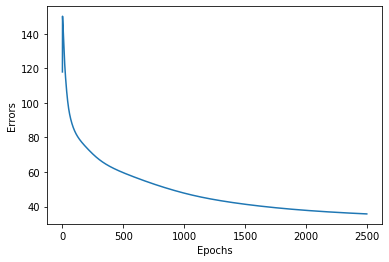

In [15]:
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.ylabel('Errors')
    plt.xlabel('Epochs')
    plt.show()
    
plot_error(nn)

In [16]:
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Test Accuracy: 80.78%


Pour le réseau de neurone nous simplement découper nôtres ensemble de donnés en trois un ensemble train, test et un ensemble de validation. Nous avons testé avec plusieurs hyperparamètres les paramètres que nous avons présentement semble atteindre les limite de la capacité de notre réseau sans prendre une éternité. Nous pouvons gagner encore quelque centième de pourcentage en augmentant le nombre de epochs mais cela ne veut pas la peine.

Le hyperparametre: 

    n_hidden_units=50
    epochs=2500
    learning_rate=0.001
    n_batches=35

In [17]:
y_train_pred = nn.predict(X_train)
y_test_pred = nn.predict(X_test)
y_pred = nn.predict(X_val)

### Matrice de confusion ensemble "train"

In [18]:
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))


[[612   0   5   1   9   0   6   8]
 [  0 610   0   3   0  21   0   7]
 [ 70   0 480   0  38   0  50  11]
 [  2  15   0 446   9  94   0  58]
 [ 19   0  23   2 589   0   0  17]
 [  6  34   0  19   1 586   0  28]
 [  5   0 149   0   5   0 478   0]
 [  3  18   2  59  10  80   0 457]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       641
           1       0.90      0.95      0.93       641
           2       0.73      0.74      0.73       649
           3       0.84      0.71      0.77       624
           4       0.89      0.91      0.90       650
           5       0.75      0.87      0.81       674
           6       0.90      0.75      0.82       637
           7       0.78      0.73      0.75       629

    accuracy                           0.83      5145
   macro avg       0.83      0.83      0.83      5145
weighted avg       0.83      0.83      0.83      5145



### Matrice de confusion ensemble "test"

In [19]:
print(confusion_matrix(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))

[[188   0   2   1   5   2   0   4]
 [  1 180   0   3   0   8   0   1]
 [ 14   0 145   0  18   0  11   9]
 [  3   3   0 153   1  27   0  17]
 [  6   0   7   1 173   0   0   8]
 [  4  17   0   6   0 151   0  16]
 [  3   0  54   0   4   0 150   0]
 [  0   9   0  19   0  25   0 159]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       202
           1       0.86      0.93      0.90       193
           2       0.70      0.74      0.72       197
           3       0.84      0.75      0.79       204
           4       0.86      0.89      0.87       195
           5       0.71      0.78      0.74       194
           6       0.93      0.71      0.81       211
           7       0.74      0.75      0.75       212

    accuracy                           0.81      1608
   macro avg       0.81      0.81      0.81      1608
weighted avg       0.81      0.81      0.81      1608



### Matrice de confusion ensemble "Val"

In [20]:
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

[[158   0   1   0   0   1   0   2]
 [  0 153   0   0   0  18   0   0]
 [ 18   0 116   0   9   0  14   2]
 [  2   5   0 131   4  25   0  10]
 [  1   0   3   1 148   0   0   8]
 [  1   6   0   2   0 119   0   9]
 [  2   0  35   0   6   0 113   0]
 [  0  14   1  17   6  25   0 101]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       162
           1       0.86      0.89      0.88       171
           2       0.74      0.73      0.74       159
           3       0.87      0.74      0.80       177
           4       0.86      0.92      0.89       161
           5       0.63      0.87      0.73       137
           6       0.89      0.72      0.80       156
           7       0.77      0.62      0.68       164

    accuracy                           0.81      1287
   macro avg       0.81      0.81      0.80      1287
weighted avg       0.81      0.81      0.81      1287



# Bonus

## KNN + Cross-validation 

KNN avec Cross-validation est une méthode ou on sépare un dataset en 'K' groupes. Un des groupes sera utilisé pour les "Test" set et le reste pour le "Training" set. Les résultats du Test accuracy et F1 scores sont légèrement meilleur que notre modèle.

In [21]:
def knn_model (X_train, X_test, y_train, y_test, weights):
    
    print()
    
    KNN_acc_uniform = []
    KNN_f1_uniform = []

    KNN_acc_distance = []
    KNN_f1_distance = []
    
    knnParams = [3,5,10]

    for neighbors in knnParams:

        model = KNeighborsClassifier(n_neighbors = neighbors, weights=weights)
        KNNmodel = model.fit(X_train, y_train)
        y_pred = KNNmodel.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted') 

        KNN_acc_uniform.append(acc)
        KNN_f1_uniform.append(f1)
        
        # Accuracy Score
        print("Accuracy score : KNN avec k = "+str(neighbors) +" et poid = "+weights)
        print(KNNmodel.score(X_test, y_test))

        print("F1 score : KNN")
        print(f1_score(y_test, y_pred, average='weighted'))
        
        clf = KNeighborsClassifier(n_neighbors= neighbors, weights='distance')
        
        ## KNN - Cross-validation
        
        print('KNN - Cross-validation')
        KNN_scores = cross_val_score(clf, X, y, cv= 10)
        print(sum(KNN_scores)/10)
        print('\n')
       

In [22]:
knn_model(X_train, X_test, y_train, y_test, 'uniform')
knn_model(X_train, X_test, y_train, y_test, 'distance')



Accuracy score : KNN avec k = 3 et poid = uniform
0.8128109452736318
F1 score : KNN
0.8133789989680407
KNN - Cross-validation
0.8411587579631151


Accuracy score : KNN avec k = 5 et poid = uniform
0.8078358208955224
F1 score : KNN
0.8083760500268292
KNN - Cross-validation
0.8455062208243505


Accuracy score : KNN avec k = 10 et poid = uniform
0.7935323383084577
F1 score : KNN
0.7936523882289324
KNN - Cross-validation
0.850116361257591



Accuracy score : KNN avec k = 3 et poid = distance
0.8302238805970149
F1 score : KNN
0.8309934169201614
KNN - Cross-validation
0.8411587579631151


Accuracy score : KNN avec k = 5 et poid = distance
0.8327114427860697
F1 score : KNN
0.8331266210872238
KNN - Cross-validation
0.8455062208243505


Accuracy score : KNN avec k = 10 et poid = distance
0.8246268656716418
F1 score : KNN
0.8246207420340512
KNN - Cross-validation
0.850116361257591




## Support Vector Machine (SVM lineair)

In [23]:
svc = SVC(cache_size=1800)

param = {'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10],'class_weight': ['balanced'],'gamma': ['scale']}

grid_linear = GridSearchCV(svc, param_grid=param, cv=10, n_jobs=5, scoring='accuracy', verbose=4)

grid_linear.fit(X_train, y_train)

print("LINEAR : The best hyperparameters are %s with a score of %0.2f" % (grid_linear.best_params_, grid_linear.best_score_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:   17.0s finished


LINEAR : The best hyperparameters are {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'} with a score of 0.78


In [24]:
accuracy=pd.DataFrame(grid_linear.cv_results_['mean_test_score'],index=[x['C'] for x  in grid_linear.cv_results_['params']],columns=['accuracy'])
print(accuracy)

        accuracy
0.001   0.139942
0.100   0.648202
1.000   0.738192
10.000  0.781924


## Reseaux de neurones

In [25]:
 from sklearn.neural_network import MLPClassifier

In [1]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X, y)

NameError: name 'MLPClassifier' is not defined

In [27]:
y_test_pred = mlp.predict(X_test)
    
y_train_pred = mlp.predict(X_train)
    
y_pred = mlp.predict(X_val)

In [28]:
# Final evaluation of the model (On the Training, Validation or Test dataset)
    
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))

[[  0   0   0   0   0   0 641   0]
 [  0   0   0   0   0   0 641   0]
 [  0   0   0   0   0   0 649   0]
 [  0   0   0   0   0   0 624   0]
 [  0   0   0   0   0   0 650   0]
 [  0   0   0   0   0   0 674   0]
 [  0   0   0   0   0   0 637   0]
 [  0   0   0   0   0   0 629   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       641
           1       0.00      0.00      0.00       641
           2       0.00      0.00      0.00       649
           3       0.00      0.00      0.00       624
           4       0.00      0.00      0.00       650
           5       0.00      0.00      0.00       674
           6       0.12      1.00      0.22       637
           7       0.00      0.00      0.00       629

    accuracy                           0.12      5145
   macro avg       0.02      0.12      0.03      5145
weighted avg       0.02      0.12      0.03      5145



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
print(confusion_matrix(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))

[[  0   0   0   0   0   0 202   0]
 [  0   0   0   0   0   0 193   0]
 [  0   0   0   0   0   0 197   0]
 [  0   0   0   0   0   0 204   0]
 [  0   0   0   0   0   0 195   0]
 [  0   0   0   0   0   0 194   0]
 [  0   0   0   0   0   0 211   0]
 [  0   0   0   0   0   0 212   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.00      0.00      0.00       193
           2       0.00      0.00      0.00       197
           3       0.00      0.00      0.00       204
           4       0.00      0.00      0.00       195
           5       0.00      0.00      0.00       194
           6       0.13      1.00      0.23       211
           7       0.00      0.00      0.00       212

    accuracy                           0.13      1608
   macro avg       0.02      0.12      0.03      1608
weighted avg       0.02      0.13      0.03      1608



## Conclusion

Pour conclure, nous avons construit un modèles d'apprentissage machine pour la reconnaissance d'objets simple. En utilisant des manipulation et altération d'image, nous avons permis à notre système d'identifier plus simplement des marqueurs. Une fois notre réseau neurone implementer, nous avons pus extraire des résultats et comparer avec d'autre librairie d'apprentissage machine. Notre rapport nous a donné l'occasion d'analyser notre conception. Dans les circonstances actuelles que nous sommes en ce moment, il était plus difficile de collaborer efficacement sur le projet, mais nous avons persévérer. 